# 使用CUSUM控制图寻找变点

基于长江证券金融工程报告[**变点理论在择时中的应用：CUSUM控制图**](https://max.book118.com/html/2017/0726/124391946.shtm)


## 变点理论

变点是指在一个序列或过程中，当某个统计特性（分布类型、分布参数）在某时间点发生变化，随机过程异质，称该时间点即为变点。过程仅受随机因素影响时，处于受控状态，存在系统因素影响时，处于失控状态。

## 控制图技术

控制图是统计过程最直接的应用，利用数理统计方法和计算机技术对工业过程或其他领域中的一个或多个变量进行监控，判断变量是否偏离典型分布、发生异动。控制图技术可减少偶然因素和异常因素判断的主观性，通过重复性的工作，可较大程度地降低工作量。其主要表现形式是具有控制线（中心线 CL、上控制界限 UCL、下控制界限 LCL）和样本统计量（按时间序列抽取的描点序列）的统计图，通过预先设定的控制线，客观科学的区别和判断两类因素（系统性因素和偶然性因素）所引起的波动。因此，构建控制图核心问题就是经济合理的确定统计量和控制线。

## 择时原理

控制图作为检测变点的一种典型方法，在工业生产应用中得到了广泛的应用，并形成一套成熟的体系。同样是通过抽取样本对产品的总体分布进行检测，我们完全可以将控制图的方法应用于股票技术择时中来，以检测变量的均值漂移过程。本文基于变点控制图图的基本原理，以股价对数收益率符合局部正态分布为基本原理，构建三大控制图（Shewhart 控制图、CUSUM 控制图、EWMA
控制图）的统计量和控制限，一旦统计量突破阈值即判断出现变点。以股价上升时对数收益率出现上升变点作为买入时机，以股价下降时对数收益率出现下降变点作为卖出时机进行择时判别。

## 数据概览

* 使用沪深300指数收盘数据
* 数据频率：15分钟
* 价格使用前复权数据
* 时间范围2017-01-01-->2020-03-27



从Wind获取数据

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
from WindPy import *

w.start()
error,df5min=w.wsi("000300.SH", "close", "2017-01-01 09:00:00", "2020-03-27 14:25:00", "BarSize=15;Fill=Previous", usedf=True)
df5min.head()

,close
2017-03-28 09:45:00,3476.10
2017-03-28 10:00:00,3481.12
2017-03-28 10:15:00,3472.64
2017-03-28 10:30:00,3471.48
2017-03-28 10:45:00,3468.25


数据描述性统计

In [32]:
df5min.describe()

,close
count,11710.000000
mean,3719.988616
std,309.190054
min,2958.920000
25%,3481.045000
50%,3792.165000
75%,3938.682525
max,4399.470000


使用CUSUM计算得到变点数据

In [33]:

def detect_via_cusum_lg(ts, istart=30, threshold_times=5):
    """
    detect a time series using  cusum algorithm
    :param ts: the time series to be detected
    :param istart: the data from index 0 to index istart will be used as cold startup data to train
    :param threshold_times: the times for setting threshold
    :return:
    """
    S_h = 0
    S_l = 0
    S_list = np.zeros(istart) # 前面填充的30个空数据
    meanArray = talib.SMA(ts,timeperiod = istart)
    stdArray = talib.STDDEV(np.log(ts/meanArray),timeperiod = istart)
    for i in range(istart, len(ts)): # 这里是否应该掐头去尾？
        tslog = np.log(ts[i] / meanArray[i - 1])
        S_h_ = max(0, S_h + tslog - stdArray[i-1])
        S_l_ = min(0, S_l + tslog + stdArray[i-1])
        if S_h_> threshold_times * stdArray[i-1]:
            S_list = np.append(S_list,1) # 该点为上变点
            S_h_ = 0
        elif abs(S_l_)> threshold_times *  stdArray[i-1]:
            S_list = np.append(S_list, -1) # 该点为下变点
            S_l_ = 0
        else:
            S_list = np.append(S_list, 0) # 该点无特殊情况
        S_h = S_h_
        S_l = S_l_

    return S_list

#数据导入
dt0 = np.array(df5min["close"])
s_list = detect_via_cusum_lg(dt0,istart=30, threshold_times=10)

In [34]:
listup,listdown = [],[]
for i in range(0,len(s_list)):
    if s_list[i] == 1:
        listup.append(i)
    elif s_list[i] == -1 :
        listdown.append(i)
signal_df=df5min["close"]


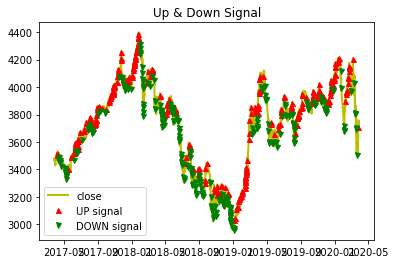

In [35]:

plt.subplot(1,1,1)
plt.plot(signal_df, color='y', lw=2.)
plt.plot(signal_df, '^', markersize=5, color='r', label='UP signal', markevery=listup)
plt.plot(signal_df, 'v', markersize=5, color='g', label='DOWN signal', markevery=listdown)
plt.legend()

plt.title('Up & Down Signal')
# plt.subplot(2,1,2)
# plt.title('s_list')
# plt.plot(s_list,'r-')
plt.show()

对得到的变点数据，判断买入点和卖出点，计算指数和策略的收益率

In [39]:
r_i=df5min['close']/df5min['close'].shift(1)
cum_return=pd.DataFrame(df5min['close']/df5min['close'][0])
cumr_s=[1] # 策略收益率列表
hold_flag=0
for i in range(1,df5min.shape[0]):
    if s_list[i]==1 and hold_flag==0: # 上升拐点且未持有
        hold_flag=1
        #print(i,'buy')
    elif s_list[i]==-1 and hold_flag==1: # 下降拐点且持有
        hold_flag=0
        #print(i,'sell')
    if hold_flag==1:
        cumr_s.append(cumr_s[i-1]*r_i[i])
    else:
        cumr_s.append(cumr_s[i-1])
cum_return.insert(1,'cumr_s',cumr_s)
cum_return.columns=['index','stratety']
cum_return.tail(5)

,index,stratety
2020-03-27 13:30:00,1.073009,1.388818
2020-03-27 13:45:00,1.074335,1.390534
2020-03-27 14:00:00,1.075065,1.391478
2020-03-27 14:15:00,1.073241,1.389118
2020-03-27 14:30:00,1.071548,1.386926


绘制收益率的对比图像如下：

注：各项指标由于使用的是15分钟数据，所有指标频率为分钟，年化收益率值不准确


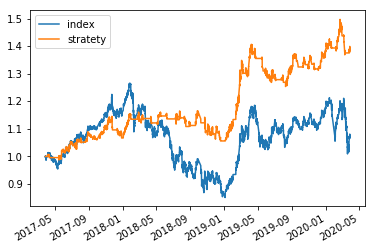

,信息比率,累计收益率,年化收益率,每日收益率,年化波动率,最大每日收益,最大每日损失,上涨天数,下跌天数,胜率,上涨时平均每日收益率,下跌时平均每日收益率,盈亏比,最大回撤
index,0.055508,1.071548,0.002529,0.000010,0.045568,0.02715,-0.072546,5809.0,5892.0,0.496453,0.001881,-0.001835,1.025316,0.327437
stratety,0.266895,1.386926,0.007427,0.000029,0.027827,0.02715,-0.026950,3092.0,2918.0,0.514476,0.001674,-0.001656,1.011120,0.108817


In [37]:
cum_return.plot()
plt.show()

from Ratio import ratio
single_day_r=(cum_return/(cum_return).shift(1))-1 # 计算指数和策略的单日收益率
result=ratio().cal_ratio(single_day_r)
result.T